# Calibration

In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

## Load data

In [2]:
data_file = "data/data.csv"
data = pd.read_csv(data_file)
data.head()

,profile_id,output_power,velocity,width,delta_length,distance,needle_length,specimen_temperature,estimated_energy
0,1,96.404523,0.058333,26.894942,22.327688,35,14,23.4,57.842714
1,1,96.924242,0.058333,24.606061,20.700043,35,14,23.6,58.154545
2,1,100.890564,0.058333,27.862069,20.545857,35,14,23.2,60.534338
3,1,101.372910,0.058333,28.784628,19.292021,35,14,23.3,60.823746
4,1,100.278220,0.058333,31.448725,21.184866,35,14,24.0,60.166932


### Basic visual inspection

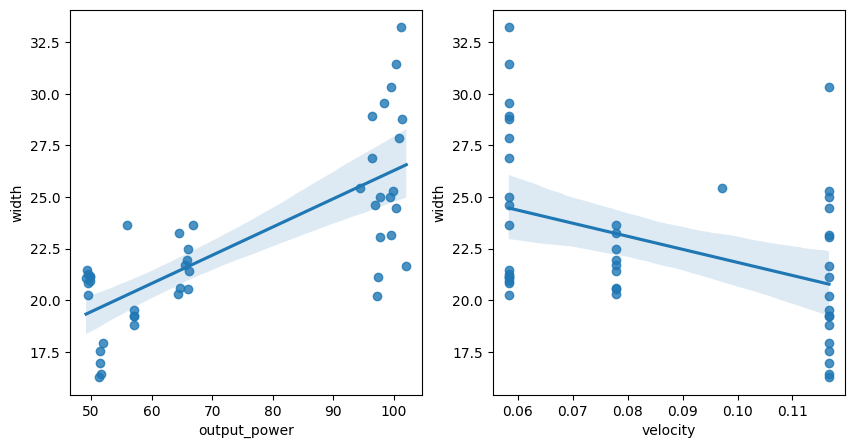

In [3]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.regplot(data = data, x = "output_power", y = "width");
plt.subplot(1, 2, 2)
sns.regplot(data = data, x = "velocity", y = "width");

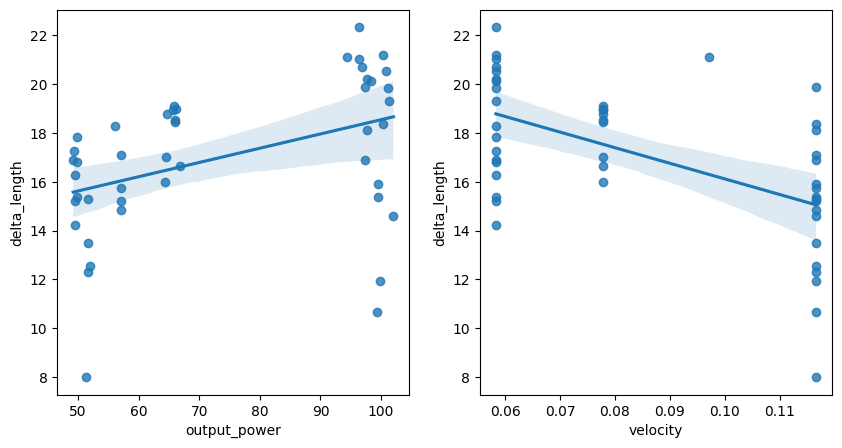

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.regplot(data = data, x = "output_power", y = "delta_length");
plt.subplot(1, 2, 2)
sns.regplot(data = data, x = "velocity", y = "delta_length");

## Model fitting

In [5]:
X = data[['output_power', 'velocity']].values.astype(np.float32)
y = data[['width', 'delta_length']].values.astype(np.float32)
print(X.shape, y.shape)
print(X.dtype, y.dtype)

(46, 2) (46, 2)
float32 float32


In [6]:

with pm.Model() as model:
    # define priors
    w_intercept = pm.Data('w_intercept', 0, mutable=False)
    w_power = pm.Normal('w_power', 3, 2)
    w_velocity = pm.Normal('w_velocity', -3, 2)

    w_eta = pm.Exponential('w_eta', 1)
    w_eta_power = pm.Exponential('w_eta_power', 1)
    w_eta_velocity = pm.Exponential('w_eta_velocity', 1)
    
    l_intercept = pm.Normal('l_intercept', 0, 10)
    l_power = pm.Normal('l_power', 3, 2)
    l_velocity = pm.Normal('l_velocity', -1, 2)
    
    l_eta = pm.Exponential('l_eta', 1)
    l_eta_power = pm.Exponential('l_eta_power', 1)
    l_eta_velocity = pm.Exponential('l_eta_velocity', 1)
    
    # data
    X_ = pm.Data('features', X, mutable=True)

    # predictions width
    width_mu = pm.Deterministic('width_mu', w_intercept + w_power * np.log(X_[:,0]) + w_velocity * np.log(X_[:,1]))
    width_sd = pm.Deterministic('width_sd', w_eta + w_eta_power * X_[:,0] + w_eta_velocity * X_[:,1])
    width_obs = pm.Normal('width', width_mu, width_sd, observed=y[:,0])
    
    # predictions delta length
    length_mu = pm.Deterministic('length_mu', l_intercept + l_power * np.log(X_[:,0]) + l_velocity * np.log(X_[:,1]))
    length_sd = pm.Deterministic('length_sd', l_eta + l_eta_power * X_[:,0] + l_eta_velocity * X_[:,1])
    length_obs = pm.Normal('length', length_mu, length_sd, observed=y[:,1])
    
    # use MCMC to sample
    trace = pm.sample(draws=1000, tune=1000, chains=4, cores=1)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [w_power, w_velocity, w_eta, w_eta_power, w_eta_velocity, l_intercept, l_power, l_velocity, l_eta, l_eta_power, l_eta_velocity]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 217 seconds.


### Show summary

In [7]:
az.summary(trace, var_names=["~width_mu", "~width_sd", "~length_mu", "~length_sd"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_power,3.516,0.544,2.419,4.563,0.011,0.008,2623.0,2628.0,1.00
w_velocity,-2.798,0.878,-4.537,-1.072,0.017,0.012,2677.0,2537.0,1.00
l_intercept,-11.670,4.563,-20.288,-2.433,0.092,0.066,2486.0,2493.0,1.00
l_power,4.321,0.929,2.410,5.997,0.018,0.013,2705.0,2654.0,1.00
l_velocity,-4.095,0.909,-5.925,-2.427,0.014,0.010,3964.0,3074.0,1.00
w_eta,0.357,0.373,0.000,1.070,0.015,0.013,1376.0,691.0,1.01
w_eta_power,0.031,0.006,0.019,0.042,0.000,0.000,1429.0,648.0,1.00
w_eta_velocity,0.928,0.923,0.001,2.842,0.014,0.011,2900.0,1738.0,1.00
l_eta,0.846,0.534,0.006,1.806,0.011,0.009,2064.0,1727.0,1.00
l_eta_power,0.017,0.008,0.001,0.031,0.000,0.000,1913.0,1139.0,1.00


## Visualize predictions

In [8]:
x_new = np.vstack((np.vstack((np.linspace(0, 120, 120), np.repeat(0.1, 120))).T, 
                   np.vstack((np.linspace(0, 120, 120), np.repeat(0.05, 120))).T))
vars_to_sample = ['width_mu', 'width_sd', 'length_mu', 'length_sd']

In [9]:
x_new_power_05 = np.vstack((np.linspace(0, 120, 60), np.repeat(0.05, 60))).T
with model:
    pm.set_data({'features': x_new_power_05})
    posterior_power_05 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample, return_inferencedata=False)

x_new_power_10 = np.vstack((np.linspace(0, 120, 120), np.repeat(0.10, 120))).T
with model:
    pm.set_data({'features': x_new_power_10})
    posterior_power_10 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample, return_inferencedata=False)
    

Sampling: []


Sampling: []


In [10]:
x_new_vel_60 = np.vstack((np.repeat(60, 60), np.linspace(0, 0.12, 60))).T
with model:
    pm.set_data({'features': x_new_vel_60})
    posterior_velocity_60 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample, return_inferencedata=False)

x_new_vel_100 = np.vstack((np.repeat(100, 60), np.linspace(0, 0.12, 60))).T
with model:
    pm.set_data({'features': x_new_vel_100})
    posterior_velocity_100 = pm.sample_posterior_predictive(trace, var_names=vars_to_sample, return_inferencedata=False)

Sampling: []


Sampling: []


In [11]:
def plot_predictions(y_pred, y_std, x_gt, y_gt, x_pred, label="", _sd=1):
    y_mean = y_pred.mean(axis=0).mean(axis=0)
    y_std = y_std.mean(axis=0).mean(axis=0)

#    plt.figure(figsize=(16, 8));
    plt.plot(x_pred, y_mean, label=f"Prediction {label} ($\mu\pm {_sd}\sigma$)");
    plt.fill_between(x_pred, y_mean - _sd*y_std, y_mean + _sd*y_std, alpha=0.33); #, label='Uncertainty ($\mu\pm\sigma$)'
    plt.legend(loc='upper left');

### Predictions for witdh

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Text(0, 0.5, 'Width (mm)')

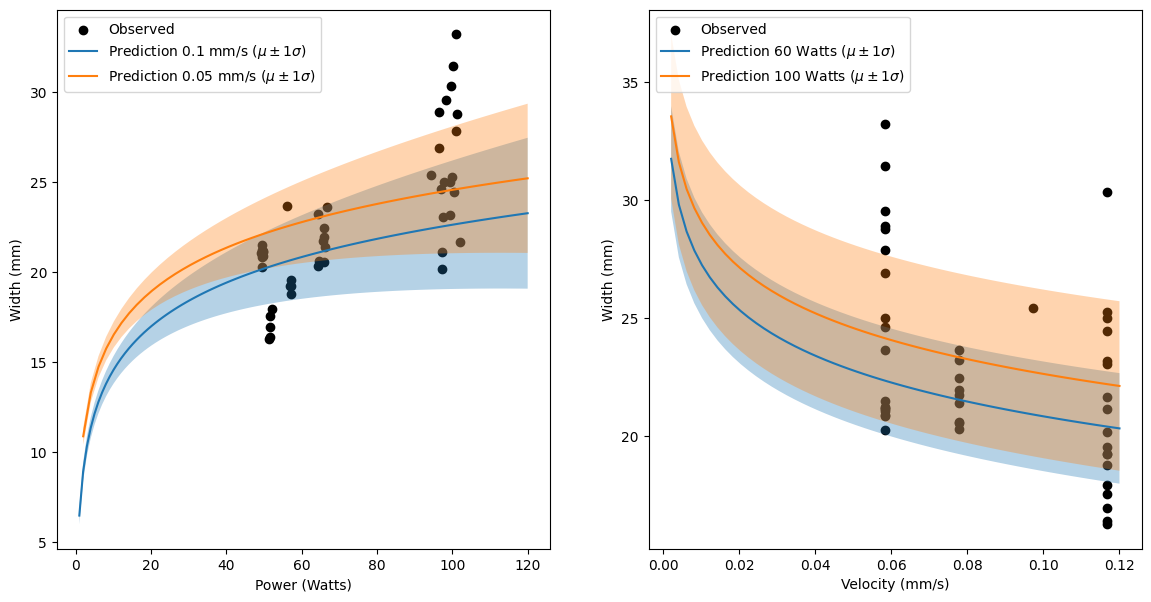

In [12]:
plt.figure(figsize=(14, 7));
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], y[:,0], color="black", label="Observed")
ix = X[:, 1] > 0.11
plot_predictions(posterior_power_10['width_mu'], posterior_power_10['width_sd'], X[ix, 0], y[ix,0], x_new_power_10[:, 0], "0.1 mm/s", _sd=1)
ix = X[:, 1] < 0.11
plot_predictions(posterior_power_05['width_mu'], posterior_power_05['width_sd'], X[ix, 0], y[ix,0], x_new_power_05[:, 0], "0.05 mm/s", _sd=1)
plt.xlabel("Power (Watts)")
plt.ylabel("Width (mm)")
#plt.ylim(0, 40)

plt.subplot(1, 2, 2)
ix = X[:, 0] < 80
plt.scatter(X[:, 1], y[:,0], color="black", label="Observed")
ix = X[:, 0] < 80
plot_predictions(posterior_velocity_60['width_mu'], posterior_velocity_60['width_sd'], X[ix, 1], y[ix,0], x_new_vel_60[:, 1], "60 Watts", _sd=1)
ix = X[:, 0] > 80
plot_predictions(posterior_velocity_100['width_mu'], posterior_velocity_100['width_sd'],X[ix, 1], y[ix,0], x_new_vel_100[:, 1], "100 Watts", _sd=1)
plt.xlabel("Velocity (mm/s)")
plt.ylabel("Width (mm)")
#plt.ylim(0, 40)

### Predictions for delta length

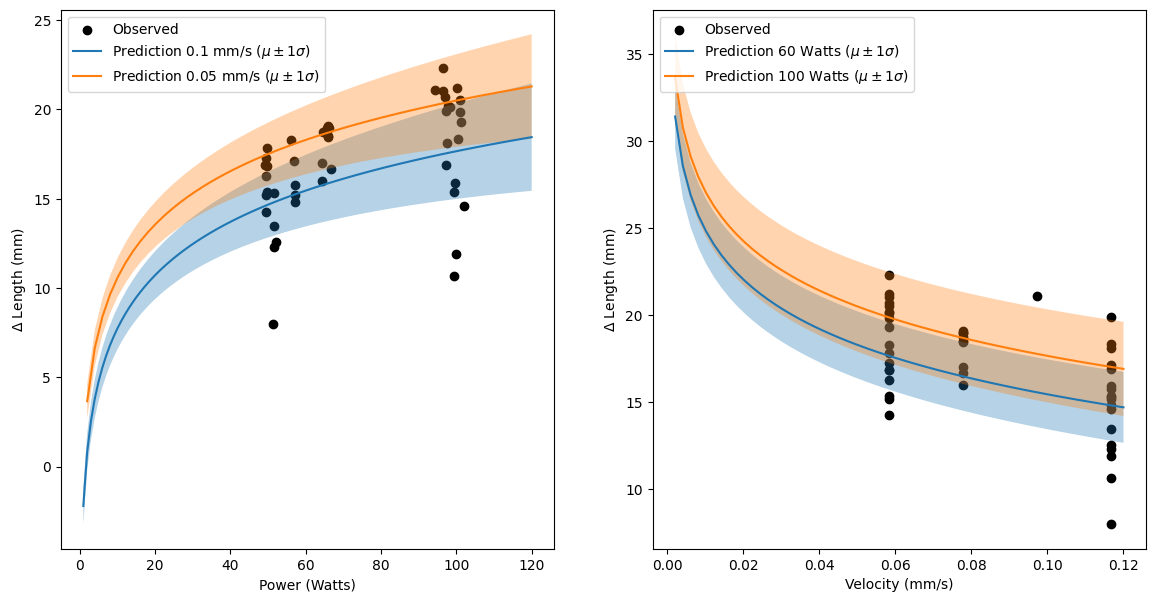

In [13]:
plt.figure(figsize=(14, 7));
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], y[:,1], color="black", label="Observed")
ix = X[:, 1] > 0.11
plot_predictions(posterior_power_10['length_mu'], posterior_power_10['length_sd'], X[ix, 0], y[ix, 1], x_new_power_10[:, 0], "0.1 mm/s", _sd=1)
ix = X[:, 1] < 0.11
plot_predictions(posterior_power_05['length_mu'], posterior_power_05['length_sd'], X[ix, 0], y[ix, 1], x_new_power_05[:, 0], "0.05 mm/s", _sd=1)
plt.xlabel("Power (Watts)")
plt.ylabel("$\Delta$ Length (mm)")
#plt.ylim(0, 40)

plt.subplot(1, 2, 2)
ix = X[:, 0] < 80
plt.scatter(X[:, 1], y[:,1], color="black", label="Observed")
ix = X[:, 0] < 80
plot_predictions(posterior_velocity_60['length_mu'], posterior_velocity_60['length_sd'], X[ix, 1], y[ix, 1], x_new_vel_60[:, 1], "60 Watts", _sd=1)
ix = X[:, 0] > 80
plot_predictions(posterior_velocity_100['length_mu'], posterior_velocity_100['length_sd'],X[ix, 1], y[ix, 1], x_new_vel_100[:, 1], "100 Watts", _sd=1)
plt.xlabel("Velocity (mm/s)")
plt.ylabel("$\Delta$ Length (mm)");
#plt.ylim(0, 40)

## Model visualization

In [14]:
pm.model_to_graphviz(model)

ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz